In [83]:
%reset -f
%load_ext autoreload
%autoreload 2
# %matplotlib tk # for pop up figures

import sys
sys.path.append('../code')

import os
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from kalman.kalman_filter import *

from fractions import Fraction
from hampel import hampel
from scipy import signal
import utility

from scipy.spatial.transform import Rotation as R

import pynumdiff
simulate = pynumdiff.utils.simulate
evaluate = pynumdiff.utils.evaluate

plt.rcParams['font.serif'] = ['Times'] + plt.rcParams['font.serif']
plt.rcParams['text.usetex'] = False
plt.rcParams["ps.usedistiller"] = 'xpdf'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.weight'] = 'normal'

%matplotlib inline

from filemanager import FileManager 
from plot_utility import mathify_ticklabels
import direct_trajectory_simulator

import kalman.filtering_custom as flt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [84]:
# Set root directory
root = r'C:\Users\bcellini\OneDrive - University of Nevada, Reno\Research\Code\bag\data\mat\hdf5'
# root = r'C:\Users\BC\OneDrive - University of Nevada, Reno\Research\Code\bag\data\mat\hdf5'

# Select file
FileSelect = FileManager() # create FileManager instance
FileSelect.Select(root) # open file selection GUI in root folder
fname = FileSelect.files[0] # full file path
basename = FileSelect.fname[0] # file name

# Make figure directoty
figdir = os.path.join(FileSelect.path[0], 'fig')
figname = os.path.join(figdir, basename)
if not(os.path.exists(figdir) and os.path.isdir(figdir)):
    os.mkdir(figdir)

# Load data
f = h5py.File(fname, 'r')

In [85]:
# Get the data
intrp = f['intrp'] # work with interpolated data
raw = f['raw'] # work with raw data
keys = list(raw.keys())
print(keys)
# list(data['imu'])

['agf', 'att', 'avf', 'gps', 'gps_sync', 'imu', 'obtrs', 'opt', 'rc', 'rtk_pos', 'rtk_vel', 'rtk_yaw', 'utc_sync', 'vel', 'vo']


## Process data

In [86]:
# Interpolated time
time = np.swapaxes(np.array(intrp['time']), 0, 1)
dt = np.mean(np.diff(time, n=1, axis=0))
T = time[-1]
fs = 1 / dt

# RC
rc = intrp['rc']
print(rc.keys())
rc_yaw = rc['yaw']
thrust_mag, thrust_dir = utility.cart2polar(
    np.squeeze(intrp['rc']['pitch']), np.squeeze(intrp['rc']['roll']))

# GPS position
gps = intrp['gps']
gps_x = np.swapaxes(np.array(gps['x']), 0, 1)
gps_y = np.swapaxes(np.array(gps['y']), 0, 1)
gps_z = np.swapaxes(np.array(gps['z']), 0, 1)

# RTK GPS position
rtk_pos = intrp['rtk_pos']
rtk_x = np.swapaxes(np.array(rtk_pos['x']), 0, 1)
rtk_y = np.swapaxes(np.array(rtk_pos['y']), 0, 1)
rtk_z = np.swapaxes(np.array(rtk_pos['z']), 0, 1)

# VO
vo = intrp['vo']
# print(vo.keys())
vo_z = np.swapaxes(np.array(vo['z']), 0, 1)

# IMU orientation
imu = intrp['imu']
print(imu.keys())
imu_yaw_unwrap = np.swapaxes(np.array(imu['yaw_unwrap']), 0, 1)

b, a = signal.butter(5, 0.5 / (fs/2))
imu_yaw_filt = signal.filtfilt(b, a, np.squeeze(imu_yaw_unwrap))

_, imu_dyaw_filt = pynumdiff.total_variation_regularization.jerk(imu_yaw_filt, dt, 20)

imu_yaw_filt = np.swapaxes(np.array(imu_yaw_filt, ndmin=2), 0, 1)
imu_dyaw_filt = np.swapaxes(np.array(imu_dyaw_filt, ndmin=2), 0, 1)

imu_yaw = imu_yaw_unwrap % (2*np.pi)
imu_yaw_filt = imu_yaw_filt % (2*np.pi)

# IMU Accleration
imu_ax = np.swapaxes(np.array(imu['ax']), 0, 1)
imu_ay = np.swapaxes(np.array(imu['ay']), 0, 1)
imu_az = np.swapaxes(np.array(imu['az']), 0, 1)

b, a = signal.butter(5, 0.2 / (fs/2))
ax_filt = signal.filtfilt(b, a, np.squeeze(imu_ax))
ay_filt = signal.filtfilt(b, a, np.squeeze(imu_ay))
a_mag, a_dir = utility.cart2polar(ax_filt, ay_filt)
a_dir = np.unwrap(a_dir)

a_mag = np.swapaxes(np.array(a_mag, ndmin=2), 0, 1)
a_dir = np.swapaxes(np.array(a_dir, ndmin=2), 0, 1)

_, a_ddir = pynumdiff.total_variation_regularization.jerk(np.squeeze(a_dir), dt, 20)
a_ddir = np.swapaxes(np.array(a_ddir, ndmin=2), 0, 1)

a_dir = utility.wrapToPi(a_dir)

# GPS Velocty
vel = intrp['vel']
# print(vel.keys())
vel_x = np.swapaxes(np.array(vel['x']), 0, 1)
vel_y = np.swapaxes(np.array(vel['y']), 0, 1)
vel_z = np.swapaxes(np.array(vel['z']), 0, 1)

b, a = signal.butter(5, 0.1 / (fs/2))
vel_x_filt = signal.filtfilt(b, a, np.squeeze(vel_x))
vel_y_filt = signal.filtfilt(b, a, np.squeeze(vel_y))
vel_x_filt = np.swapaxes(np.array(vel_x_filt, ndmin=2), 0, 1)
vel_y_filt = np.swapaxes(np.array(vel_y_filt, ndmin=2), 0, 1)

vel_mag, vel_dir = utility.cart2polar(vel_x_filt, vel_y_filt)
vel_dir_body_frame = -(vel_dir - imu_yaw)
vel_dir_body_frame = vel_dir_body_frame % (2*np.pi)

vel_x_body_frame, vel_y_body_frame = utility.polar2cart(vel_mag, vel_dir_body_frame)

# Optic flow velocity
opt = intrp['opt']
# print(opt.keys())
opt_x = -np.swapaxes(np.array(opt['vxmean']), 0, 1)
opt_y = np.swapaxes(np.array(opt['vymean']), 0, 1)

b, a = signal.butter(5, 0.1 / (fs/2))
opt_x_filt = signal.filtfilt(b, a, np.squeeze(opt_x))
opt_y_filt = signal.filtfilt(b, a, np.squeeze(opt_y))

opt_mag, opt_dir = utility.cart2polar(opt_y_filt, opt_x_filt) # might need to flip x-y
opt_dir = np.unwrap(opt_dir)

_, opt_ddir = pynumdiff.total_variation_regularization.jerk(opt_dir, dt, 20)
opt_ddir = np.swapaxes(np.array(opt_ddir, ndmin=2), 0, 1)

# opt_dir = opt_dir + (np.pi/2)
opt_dir = opt_dir % (2*np.pi)

opt_mag = np.swapaxes(np.array(opt_mag, ndmin=2), 0, 1)
opt_dir = np.swapaxes(np.array(opt_dir, ndmin=2), 0, 1)

# Onboard trisonica wind sensor
obtrs = intrp['obtrs']
# print(obtrs.keys())
air_speed_dir = np.swapaxes(np.array(obtrs['dir_unwrap']), 0, 1)

b, a = signal.butter(5, 0.2 / (fs/2))
air_speed_dir_filt = signal.filtfilt(b, a, np.squeeze(air_speed_dir))

_, air_speed_ddir = pynumdiff.total_variation_regularization.jerk(air_speed_dir_filt, dt, 20)
air_speed_ddir = np.swapaxes(np.array(air_speed_ddir, ndmin=2), 0, 1)

air_speed_dir_filt = np.swapaxes(np.array(air_speed_dir_filt, ndmin=2), 0, 1)

air_speed_dir = utility.wrapTo2Pi(air_speed_dir)
air_speed_dir_filt = utility.wrapTo2Pi(air_speed_dir_filt)

air_speed_mag = np.squeeze(np.swapaxes(np.array(obtrs['speed']), 0, 1))
air_speed_mag = np.swapaxes(np.array( hampel(pd.Series(air_speed_mag), window_size=5, n=3, imputation=True), ndmin=2), 0, 1)

air_speed_mag2 = np.squeeze(np.swapaxes(np.array(obtrs['speed2']), 0, 1))
air_speed_mag2 = np.swapaxes(np.array(hampel(pd.Series(air_speed_mag2), window_size=5, n=3, imputation=True), ndmin=2), 0, 1)

b, a = signal.butter(5, 0.2 / (fs/2))
air_speed_mag_filt = signal.filtfilt(b, a, np.squeeze(air_speed_mag))
air_speed_mag_filt = np.swapaxes(np.array(air_speed_mag_filt, ndmin=2), 0, 1)

air_speed_mag2_filt = signal.filtfilt(b, a, np.squeeze(air_speed_mag2))
air_speed_mag2_filt = np.swapaxes(np.array(air_speed_mag2_filt, ndmin=2), 0, 1)

air_speed_x, air_speed_y = utility.polar2cart(air_speed_mag2_filt, air_speed_dir_filt)

# air_speed_x = np.squeeze(np.swapaxes(np.array(obtrs['westeast']), 0, 1))
# air_speed_x = hampel(pd.Series(air_speed_x), window_size=5, n=3, imputation=True)

# air_speed_y = np.squeeze(np.swapaxes(np.array(obtrs['northsouth']), 0, 1))
# air_speed_y = hampel(pd.Series(air_speed_y), window_size=5, n=3, imputation=True)

# air_speed_z = np.squeeze(np.swapaxes(np.array(obtrs['updown']), 0, 1))
# air_speed_z = hampel(pd.Series(air_speed_z), window_size=5, n=3, imputation=True)

# r, theta = utility.cart2polar(air_speed_x, air_speed_y)

# Wind speed vector calculation
wind_speed_x = air_speed_x - vel_x_body_frame
wind_speed_y = air_speed_y - vel_y_body_frame
wind_speed_mag, wind_speed_dir = utility.cart2polar(wind_speed_x, wind_speed_y)
# wind_speed_dir = imu_yaw_filt - wind_speed_dir

<KeysViewHDF5 ['pitch', 'roll', 'throttle', 'yaw']>
<KeysViewHDF5 ['ax', 'ay', 'az', 'pitch', 'roll', 'vpitch', 'vroll', 'vyaw', 'w', 'x', 'y', 'yaw', 'yaw_unwrap', 'z']>


## Store processed data in new dataframe

In [87]:
# Concatenate data
alldata = np.concatenate((time,
                          1000*gps_x, 1000*gps_y, 1000*gps_z,
                          imu_yaw, imu_yaw_filt, imu_dyaw_filt,
                          opt_dir, opt_ddir,
                          air_speed_dir, air_speed_dir_filt, air_speed_ddir,
                          a_dir, a_ddir,
                          vel_mag,
                          air_speed_mag2, air_speed_mag2_filt,
                          a_mag,
                          wind_speed_mag,
                          wind_speed_dir ), axis=1)

names = ['t',
         'xpos', 'ypos', 'zpos',
         'phi', 'phi_filt', 'dphi',
         'psi', 'dpsi',
         'gamma', 'gamma_filt', 'dgamma',
         'alpha', 'dalpha',
         'g',
         'a', 'a_filt',
         'accel_mag',
         'w_vector',
         'zeta_vector']
   
# Create dataframe
df = pd.DataFrame(data = alldata, 
                  columns = names)
# print(df)

## Kalman filter

In [88]:
%load_ext autoreload
%autoreload 2
# # _, u = pynumdiff.total_variation_regularization.jerk(np.squeeze(imu_dyaw_filt), dt, 1)
# _, u = pynumdiff.smooth_finite_difference.friedrichsdiff(np.squeeze(imu_dyaw_filt), dt, 2, options={'iterate': False})
# kf, P0 = circKF_pos_vel(dt, sigma_a=1, sigma_y=10, sigma_p=0.9)
# X,_ = kf.runFilter(df['phi'], u, P0, x0=None, circ=True)

# _, u = pynumdiff.smooth_finite_difference.friedrichsdiff(np.squeeze(imu_dyaw_filt), dt, 2, options={'iterate': False})
# kf, P0 = circKF_pos_vel(dt, sigma_a=1, sigma_y=10, sigma_p=0.9)
# X,_ = kf.runFilter(df['phi'], u, P0=P0, x0=None, circ=True)

_, u = pynumdiff.smooth_finite_difference.friedrichsdiff(np.squeeze(df['dphi']), dt, 2, options={'iterate': False})
kf, P0 = circKF_pos_vel(dt, sigma_a=1, sigma_y=10, sigma_p=0.9)
# x0 = np.vstack((-np.pi, 0))
# X,_ = kf.runFilter(df['psi'], u, P0=P0, x0=None, circ=True)
X,_ = kf.runFilter(df['psi'], u, P0=P0, x0=None, circ=True, y_record_2=df['gamma'])


_, u = pynumdiff.smooth_finite_difference.friedrichsdiff(np.squeeze(thrust_dir), dt, 2, options={'iterate': False})
kf, P0 = circKF_pos_vel(dt, sigma_a=1, sigma_y=10, sigma_p=0.9)
X,_ = kf.runFilter(df['gamma'], u, P0=P0, x0=None, circ=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Circular Kalman Filter

4851


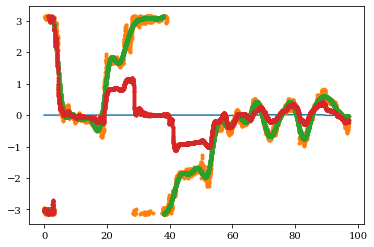

In [125]:
import kalman.filtering_custom as flt
print(len(time))
n_point = int((T/dt) + 1)

# Data
z = utility.wrapToPi(df.gamma)
z_filt = utility.wrapToPi(df.gamma_filt)
dy = df.dgamma * dt
# plt.plot(df.t, dy)

dy2 = df.dphi * dt
plt.plot(df.t, dy2)

# Parameters
kappa_phi = 1 # inverse diffusion constant
kappa_y = 10 # precision of increment observations
alpha = 1 # precision of direct observations, lin apprx
phi_0 = z[0] # initial mean
kappa_0 = 20 # initial certainty

dy = np.zeros(n_point) 
zz = np.unwrap(z_filt)
for i in range(1,n_point):
    dy[i] = np.random.normal(zz[i]-zz[i-1],0*1/np.sqrt(kappa_y) * np.sqrt(dt)) 
# plt.plot(df.t, dy)

mu_VM, kappa_VM = flt.vM_Projection_Run(T,
                                        kappa_phi,
                                        z=z,
                                        alpha=alpha,
                                        dy=0*dy,
                                        dy2=dy2,
                                        kappa_y=kappa_y,
                                        phi_0=phi_0,
                                        kappa_0=kappa_0,
                                        dt=dt)
# print(T)
# print(len(time))
# print(len(df.gamma))
# plt.plot(df.t, z_filt,  '.')

# plt.plot(df.t, df.dgamma * dt)
# plt.plot(df.t, dy)

plt.plot(df.t, z, '.')
plt.plot(df.t, z_filt, '.')
plt.plot(df.t, mu_VM, '.')
# plt.plot(*flt.circplot(df.t, mu_VM))

## Wind direction calculations

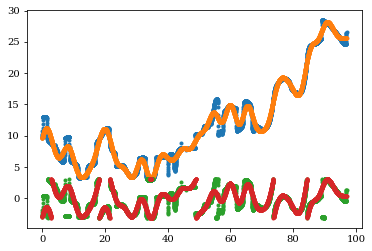

In [33]:
def contdirest(phi, psi, gamma, dphi, dpsi, dgamma):
    delta = gamma - psi
    ddelta = dgamma - dpsi
    
    zeta = 2*np.arctan((ddelta - np.sqrt( (ddelta**2) + ((np.tan(delta)**2) * ( (dgamma**2) + 2*dgamma*dphi + (dphi**2) )) )) 
    / (dgamma + dphi*np.tan(delta))) + phi + gamma
    
    return zeta

zeta_contdirest = contdirest(df.phi_filt, df.psi, df.gamma_filt, df.dphi, df.dpsi, df.dgamma)
zeta_contdirest = np.array(zeta_contdirest)
zeta_contdirest_unwrap = np.unwrap(zeta_contdirest)

plt.plot(time, zeta_contdirest_unwrap, '.')

b, a = signal.butter(5, 0.2 / (fs/2))
zeta_contdirest_filt = signal.filtfilt(b, a, np.squeeze(zeta_contdirest_unwrap))
zeta_contdirest_filt = np.swapaxes(np.array(zeta_contdirest_filt, ndmin=2), 0, 1)

plt.plot(time, zeta_contdirest_filt, '.')

zeta_contdirest = utility.wrapToPi(zeta_contdirest)
zeta_contdirest_filt = utility.wrapToPi(zeta_contdirest_filt)

plt.plot(time, zeta_contdirest, '.')
plt.plot(time, zeta_contdirest_filt, '.')


## Remote control

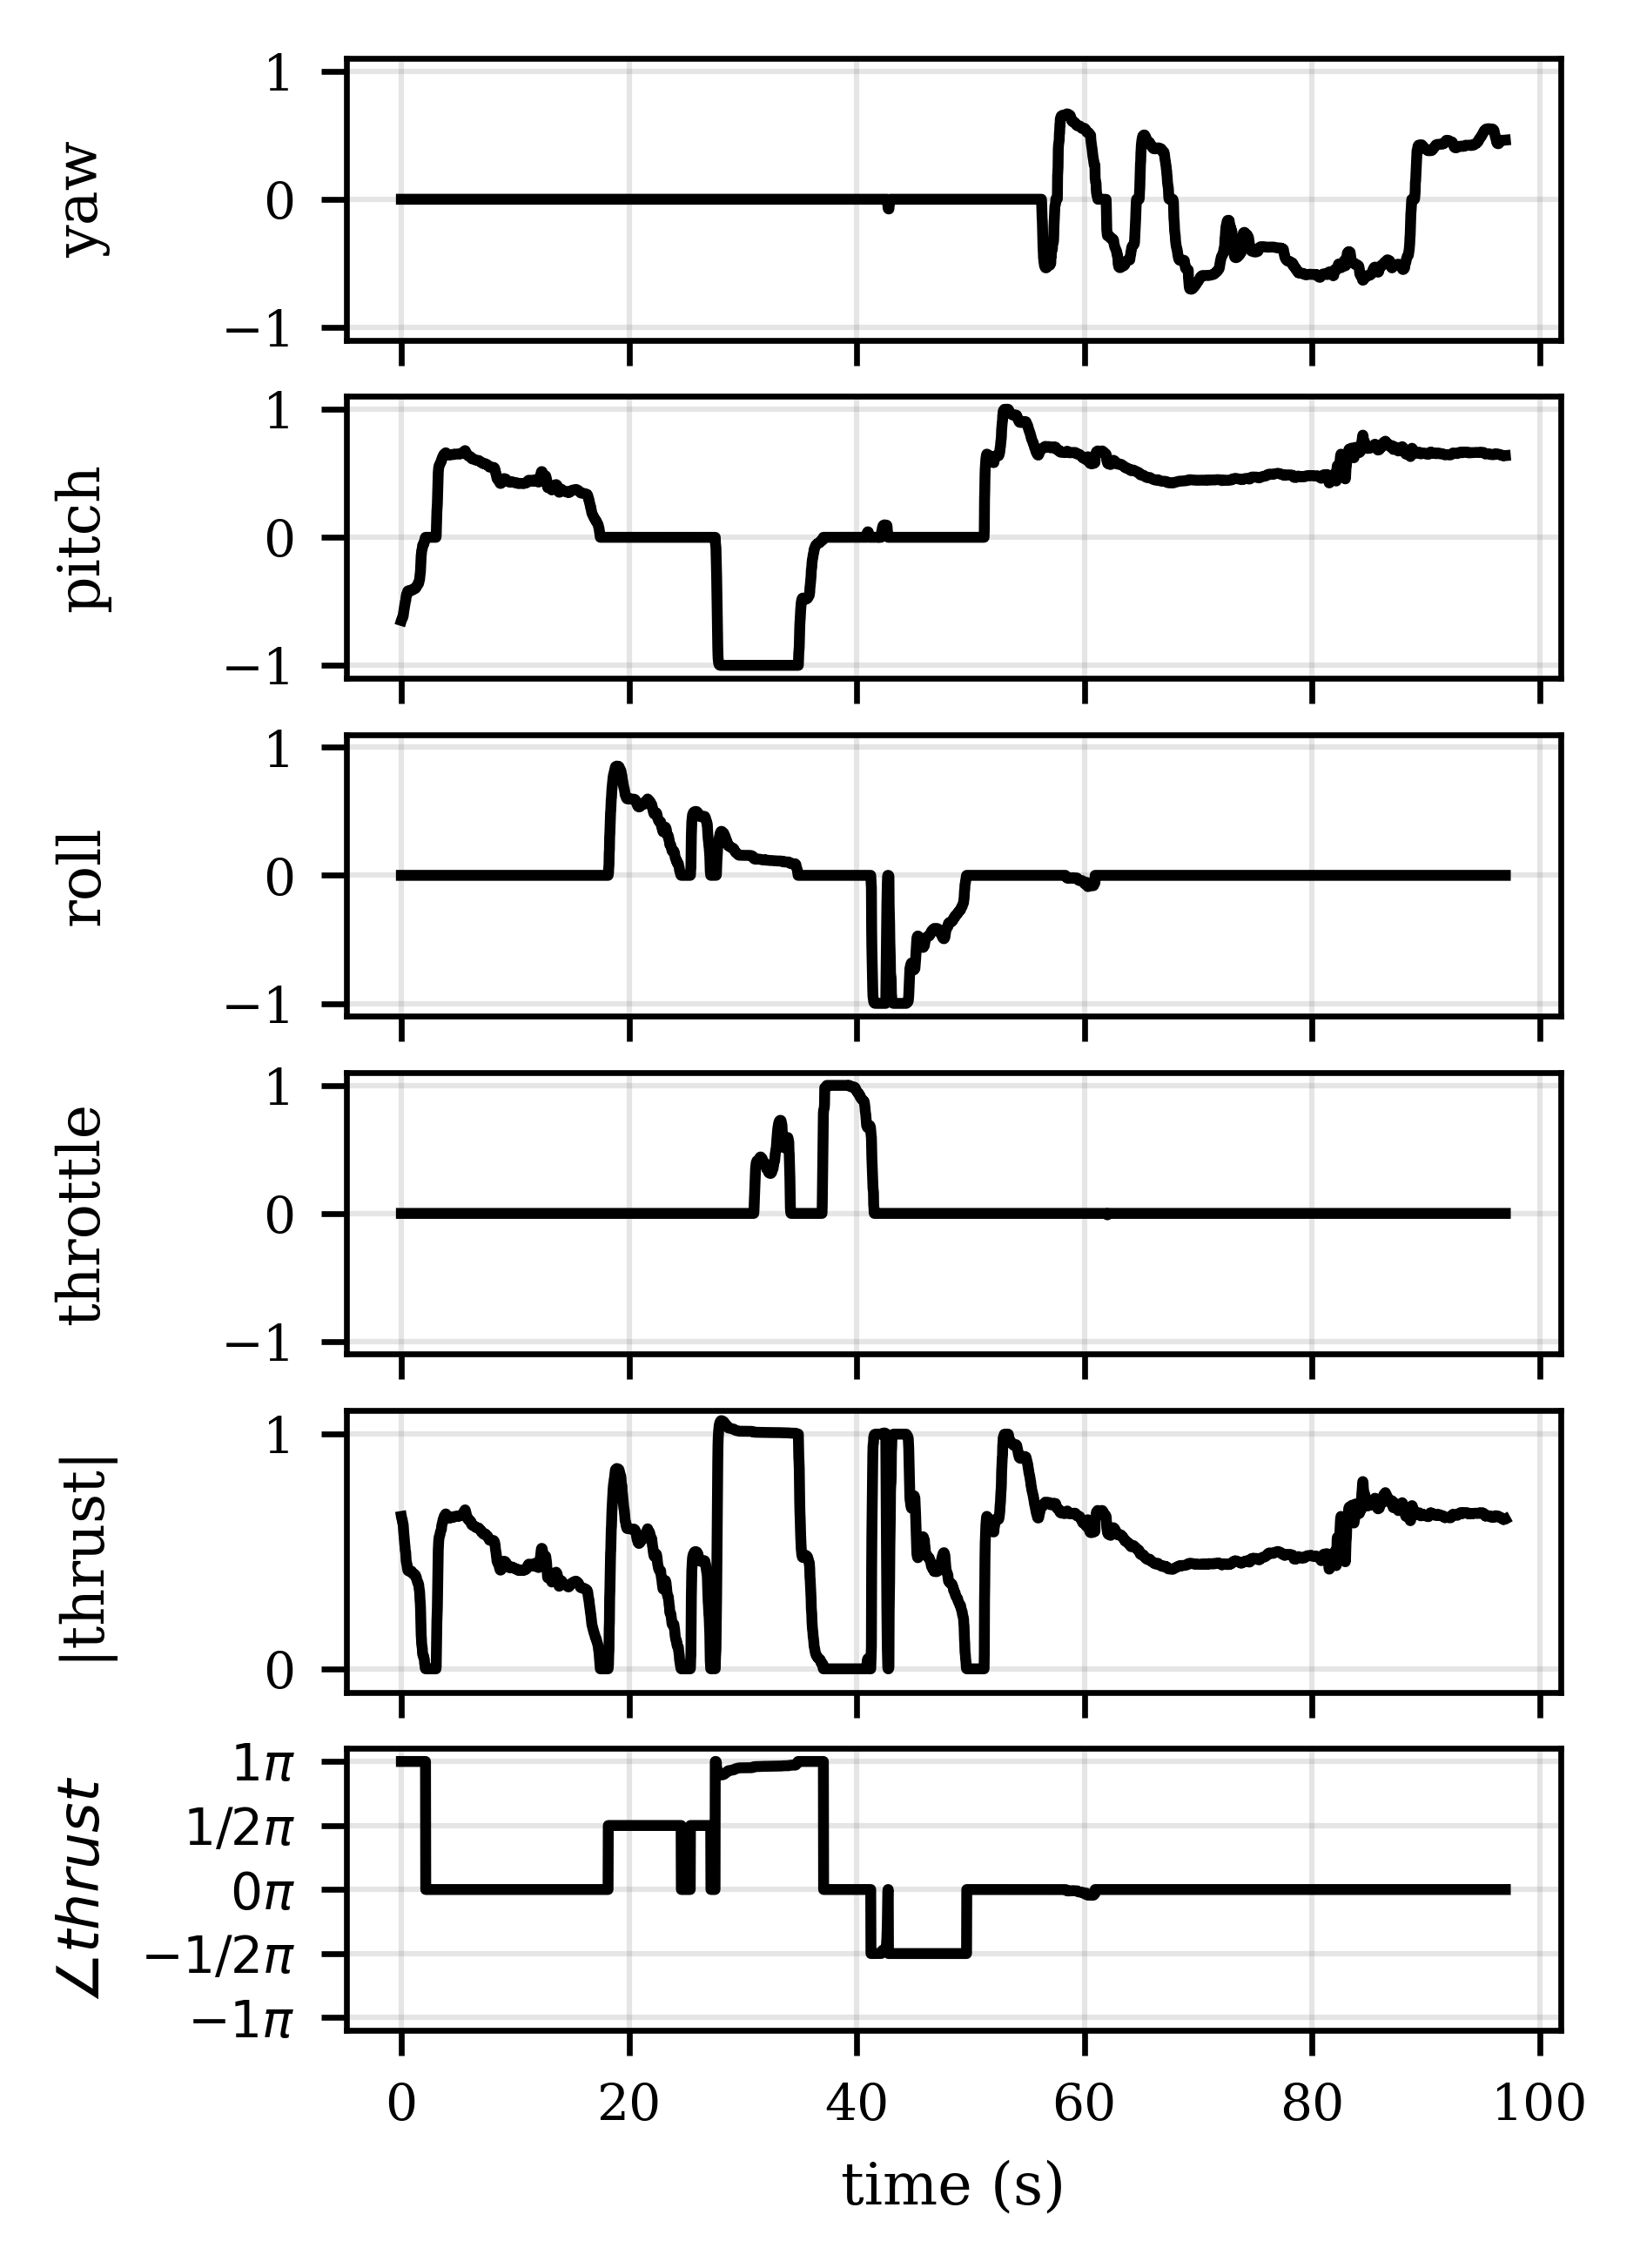

In [34]:
n_row = 6
mksz = 1.5
fig, ax = plt.subplots(n_row, 1, figsize=(3,5), dpi=600)

ax[0].plot(time, np.squeeze(intrp['rc']['yaw']), color='black',
             linestyle='-',
             linewidth=1.5,
             marker='',
             markersize=mksz,
             alpha=1)

ax[1].plot(time, np.squeeze(intrp['rc']['pitch']), color='black',
             linestyle='-',
             linewidth=1.5,
             marker='',
             markersize=mksz,
             alpha=1)

ax[2].plot(time, np.squeeze(intrp['rc']['roll']), color='black',
             linestyle='-',
             linewidth=1.5,
             marker='',
             markersize=mksz,
             alpha=1)

ax[3].plot(time, np.squeeze(intrp['rc']['throttle']), color='black',
             linestyle='-',
             linewidth=1.5,
             marker='',
             markersize=mksz,
             alpha=1)

ax[4].plot(time, np.squeeze(thrust_mag), color='black',
             linestyle='-',
             linewidth=1.5,
             marker='',
             markersize=mksz,
             alpha=1)

ax[5].plot(time, np.squeeze(thrust_dir), color='black',
             linestyle='-',
             linewidth=1.5,
             marker='',
             markersize=mksz,
             alpha=1)

ylabels = ['yaw', 'pitch', 'roll', 'throttle', '|thrust|',  r'$\angle{thrust}$']
ytickpispace = 0.5
p = 1
for a in ax.reshape(-1):
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=7)
    a.grid(color='gray', linestyle='-', linewidth=0.75, alpha=0.2)
    if p < 5:    
        a.set_ylim(-1.1 , 1.1)
    elif p < 6:
       a.set_ylim(-0.1 , 1.1)
    else:
        a.set_ylim(-1*np.pi, 1*np.pi)
        ylim = a.get_ylim()
        yticks = np.arange(ylim[0], ylim[1]+0.01, ytickpispace*np.pi)
        ytickpi = yticks / np.pi
        ytickslabels = ytickpi.tolist()
        for y in range(len(ytickslabels)):
            ytickslabels[y] = ('$'+ str(Fraction(ytickslabels[y])) + '\pi$')
        a.set_yticks(yticks)
        a.set_yticklabels(ytickslabels)
        a.set_ylim(-1.1*np.pi, 1.1*np.pi)
        
    if p < (n_row):
        a.tick_params(axis='x', labelbottom=[])
    
    a.set_ylabel(ylabels[p-1], fontsize=8)
    
    if p > (n_row - 1):
        a.set_xlabel('time (s)', fontsize=8)
        
    p = p + 1
    
fig.align_ylabels(ax)
    
plt.savefig(figname + "_remote_control.png")
plt.show()

## Main plot

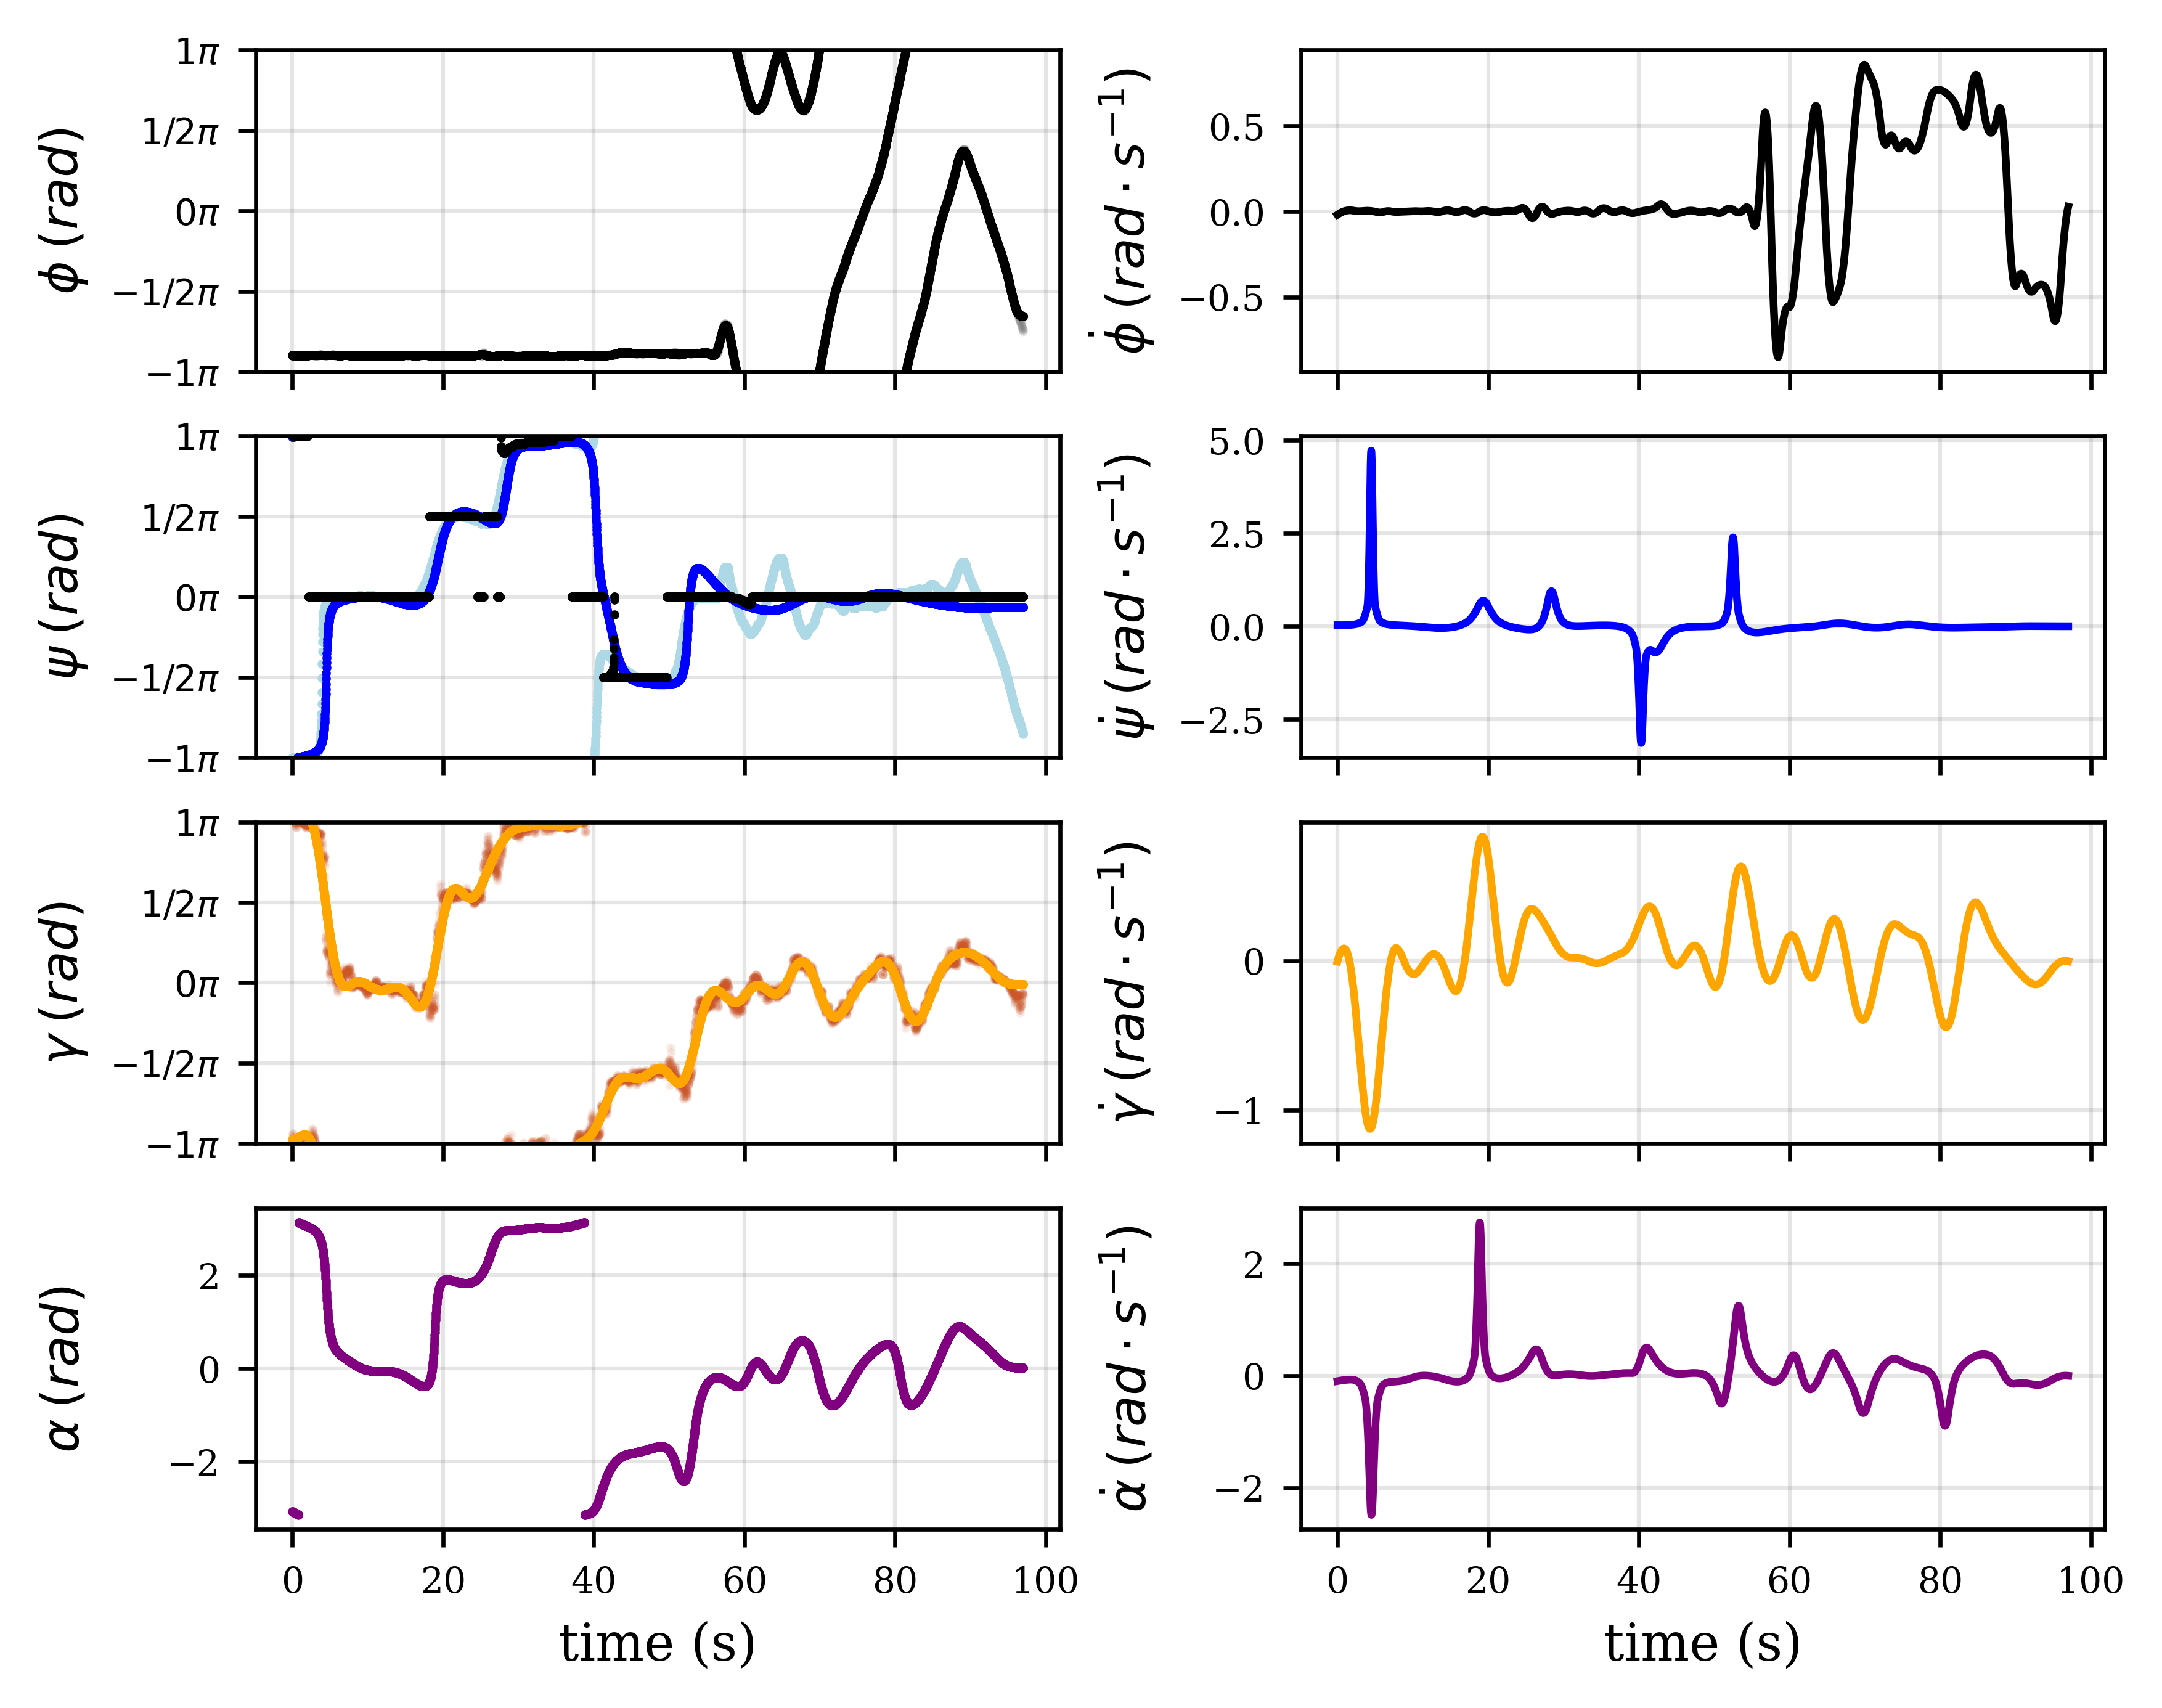

In [35]:
n_row = 4
fig, ax = plt.subplots(n_row, 2, figsize=(10,5), dpi=600)
mksz = 1.5

# Phi
ax[0,0].plot(time, utility.wrapToPi(df['phi']), color='gray',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 0.1)

ax[0,0].plot(time, utility.wrapToPi(df['phi_filt']), color='black',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 1)
# ax[0,0].plot(time, utility.wrapToPi(X[:,0]), color='red',
#              linestyle='--',
#              linewidth=1,
#              marker = '',
#              markersize=mksz,
#              alpha = 1)

# dPhi
ax[0,1].plot(time,df['dphi'], color='black',
             linestyle='-',
             linewidth=1.5,
             marker = '',
             markersize=mksz,
             alpha = 1)
# ax[0,1].plot(time, utility.wrapToPi(X[:,1]), color='red',
#              linestyle='--',
#              linewidth=1,
#              marker = '',
#              markersize=mksz,
#              alpha = 1)

# Psi
ax[1,0].plot(time, utility.wrapToPi(vel_dir_body_frame), color='lightblue',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)
ax[1,0].plot(time, utility.wrapToPi(df['psi']), color='blue',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)
ax[1,0].plot(time, utility.wrapToPi(thrust_dir), color='black',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

# ax[1,0].plot(time, utility.wrapToPi(X[:,0]), color='red',
#              linestyle='',
#              linewidth=1,
#              marker = '.',
#              markersize=mksz,
#              alpha = 1)

# dPsi
ax[1,1].plot(time,df['dpsi'], color='blue',
             linestyle='-',
             linewidth=1.5,
             marker = '',
             markersize=mksz)

# Gamma
ax[2,0].plot(time, utility.wrapToPi(df['gamma']), color=(0.80, 0.3451, 0.1647),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 0.1)

ax[2,0].plot(time, utility.wrapToPi(df['gamma_filt']), color='orange',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

# ax[2,0].plot(time, utility.wrapToPi(X[:,0]), color='red',
#              linestyle='',
#              linewidth=1,
#              marker = '.',
#              markersize=mksz,
#              alpha = 1)

#dGamma
ax[2,1].plot(time, df['dgamma'], color='orange',
             linestyle='-',
             linewidth=1.5,
             marker = '',
             markersize=mksz,
             alpha = 1)

# Alpha
ax[3,0].plot(time, utility.wrapToPi(df['alpha']), color='purple',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 1)

#dAlpha
ax[3,1].plot(time, df['dalpha'], color='purple',
             linestyle='-',
             linewidth=1.5,
             marker = '',
             markersize=mksz,
             alpha = 1)

# Plot formatting
ylabels = ['$\phi \:(rad)$', '$\dot{\phi} \:(rad \cdot s^{-1})$',
           '$\psi \:(rad)$', '$\dot{\psi} \:(rad \cdot s^{-1})$',
           '$\gamma \:(rad)$', '$\dot{\gamma} \:(rad \cdot s^{-1})$',
           r'$\alpha \:(rad)$', r'$\dot{\alpha} \:(rad \cdot s^{-1})$']

ytickpispace = 0.5
p = 1
for a in ax.reshape(-1):
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=7)
    a.grid(color='gray', linestyle='-', linewidth=0.75, alpha=0.2)
    
    if p < (n_row*2 - 2 + 1):
        a.tick_params(axis='x', labelbottom=[])
    
    a.set_ylabel(ylabels[p-1])
    if p > (n_row*2 - 2):
        a.set_xlabel('time (s)')
        
    if (np.round(p/2) != (p/2)) and (p < 7):
        a.set_ylim(-1*np.pi, 1*np.pi)
        ylim = a.get_ylim()
        yticks = np.arange(ylim[0], ylim[1]+0.01, ytickpispace*np.pi)
        ytickpi = yticks / np.pi
        # ytickpi = np.array([0, 1/2, 1, 3/2, 2])
        # yticks = np.pi * ytickpi
        ytickslabels = ytickpi.tolist()
        for y in range(len(ytickslabels)):
            ytickslabels[y] = ('$'+ str(Fraction(ytickslabels[y])) + '\pi$')
        
        a.set_yticks(yticks)
        a.set_yticklabels(ytickslabels)
        
    p = p + 1
        
left  = 0.4   # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax_dim = np.shape(ax)
for n in range(ax_dim[1]):
    fig.align_ylabels(ax[:, n])
    
plt.savefig(figname + "_sensory_data.png")
plt.show()

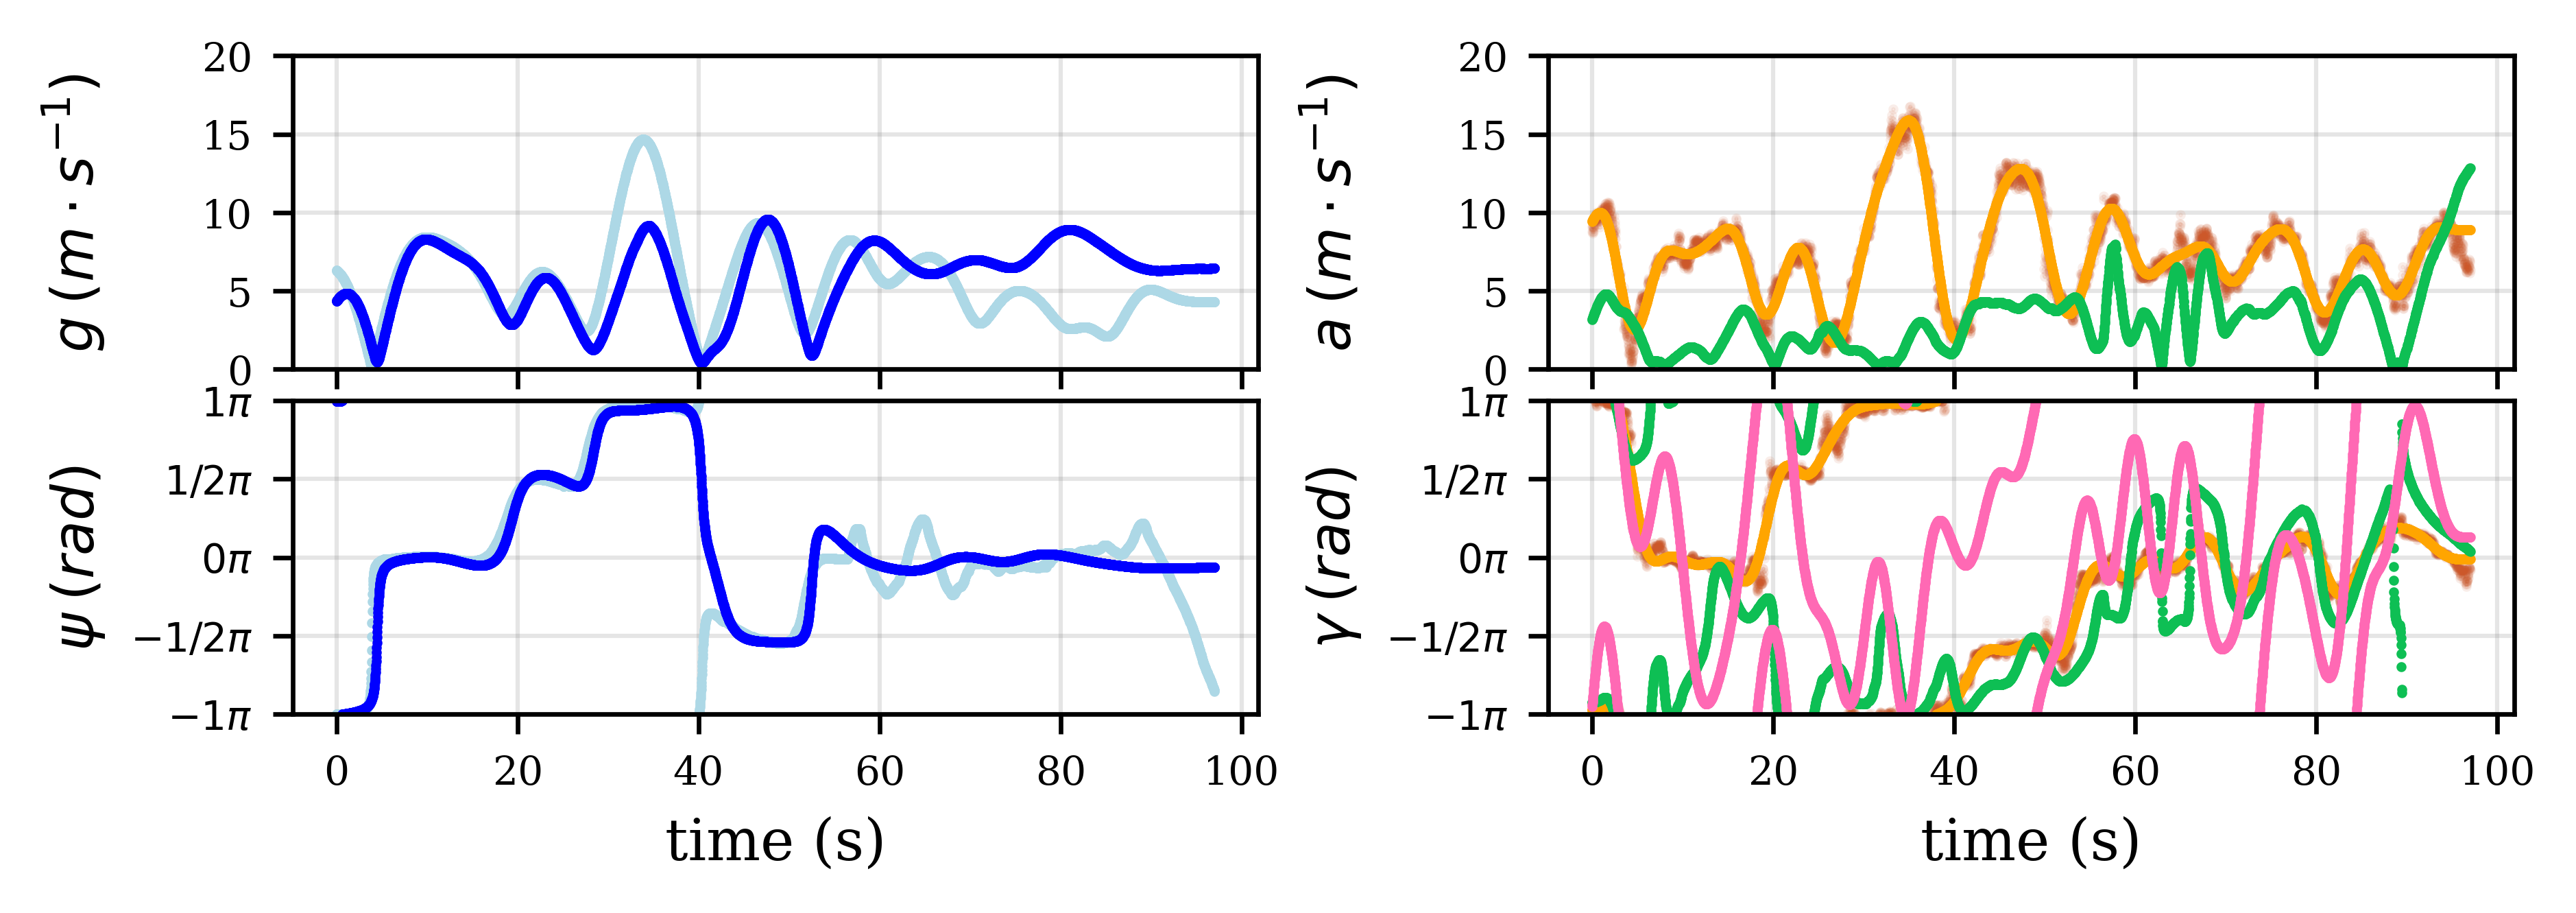

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(6,2), dpi=600)
mksz = 1.5

# g
ax[0,0].plot(time, df['g'], color='lightblue',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)
test = (30 + gps_z)*opt_mag
ax[0,0].plot(time, 0.03*test, color='blue',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)

# Psi
ax[1,0].plot(time, utility.wrapToPi(vel_dir_body_frame), color='lightblue',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)
ax[1,0].plot(time, utility.wrapToPi(df['psi']), color='blue',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

# a
ax[0,1].plot(time, df['a'], color=(0.80, 0.3451, 0.1647),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha=0.1)

ax[0,1].plot(time, df['a_filt'], color='orange',
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)

ax[0,1].plot(time, df['w_vector'], color=(0.055, 0.75, 0.33),
             linestyle='',
             linewidth=1,
             marker='.',
             markersize=mksz,
             alpha=1)

# Gamma
ax[1,1].plot(time, utility.wrapToPi(df['gamma']), color=(0.80, 0.3451, 0.1647),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz,
             alpha = 0.1)

ax[1,1].plot(time, utility.wrapToPi(df['gamma_filt']), color='orange',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ax[1,1].plot(time, utility.wrapToPi(df['zeta_vector']), color=(0.055, 0.75, 0.33),
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ax[1,1].plot(time, utility.wrapToPi(zeta_contdirest_filt), color='hotpink',
             linestyle='',
             linewidth=1,
             marker = '.',
             markersize=mksz)

ylabels = ['$g \:(m \cdot s^{-1})$', '$a \:(m \cdot s^{-1})$', r'$\psi \:(rad)$', r'$\gamma \:(rad)$']

ytickpispace = 0.5
p = 1
for a in ax.reshape(-1):
    a.tick_params(axis='x', labelsize=7)
    a.tick_params(axis='y', labelsize=7)
    a.grid(color='gray', linestyle='-', linewidth=0.75, alpha=0.2)
    
    if p < 3:
        a.tick_params(axis='x', labelbottom=[])
    
    a.set_ylabel(ylabels[p-1])
    if p > 2:
        a.set_xlabel('time (s)')
        
    if p > 2:
        a.set_ylim(-1*np.pi, 1*np.pi)
        ylim = a.get_ylim()
        yticks = np.arange(ylim[0], ylim[1]+0.01, ytickpispace*np.pi)
        ytickpi = yticks / np.pi
        ytickslabels = ytickpi.tolist()
        for y in range(len(ytickslabels)):
            ytickslabels[y] = ('$'+ str(Fraction(ytickslabels[y])) + '\pi$')
        a.set_yticks(yticks)
        a.set_yticklabels(ytickslabels)
    else:
        a.set_yticks(np.arange(0,50,5))
        a.set_ylim(0, 20)
        
    p = p + 1
    
left  = 0.0  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.1   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

ax_dim = np.shape(ax)
for n in range(ax_dim[1]):
    fig.align_ylabels(ax[:, n])

# plt.savefig(figname + "_vel_vs_airspeed.png")

## Trajectory + orientation

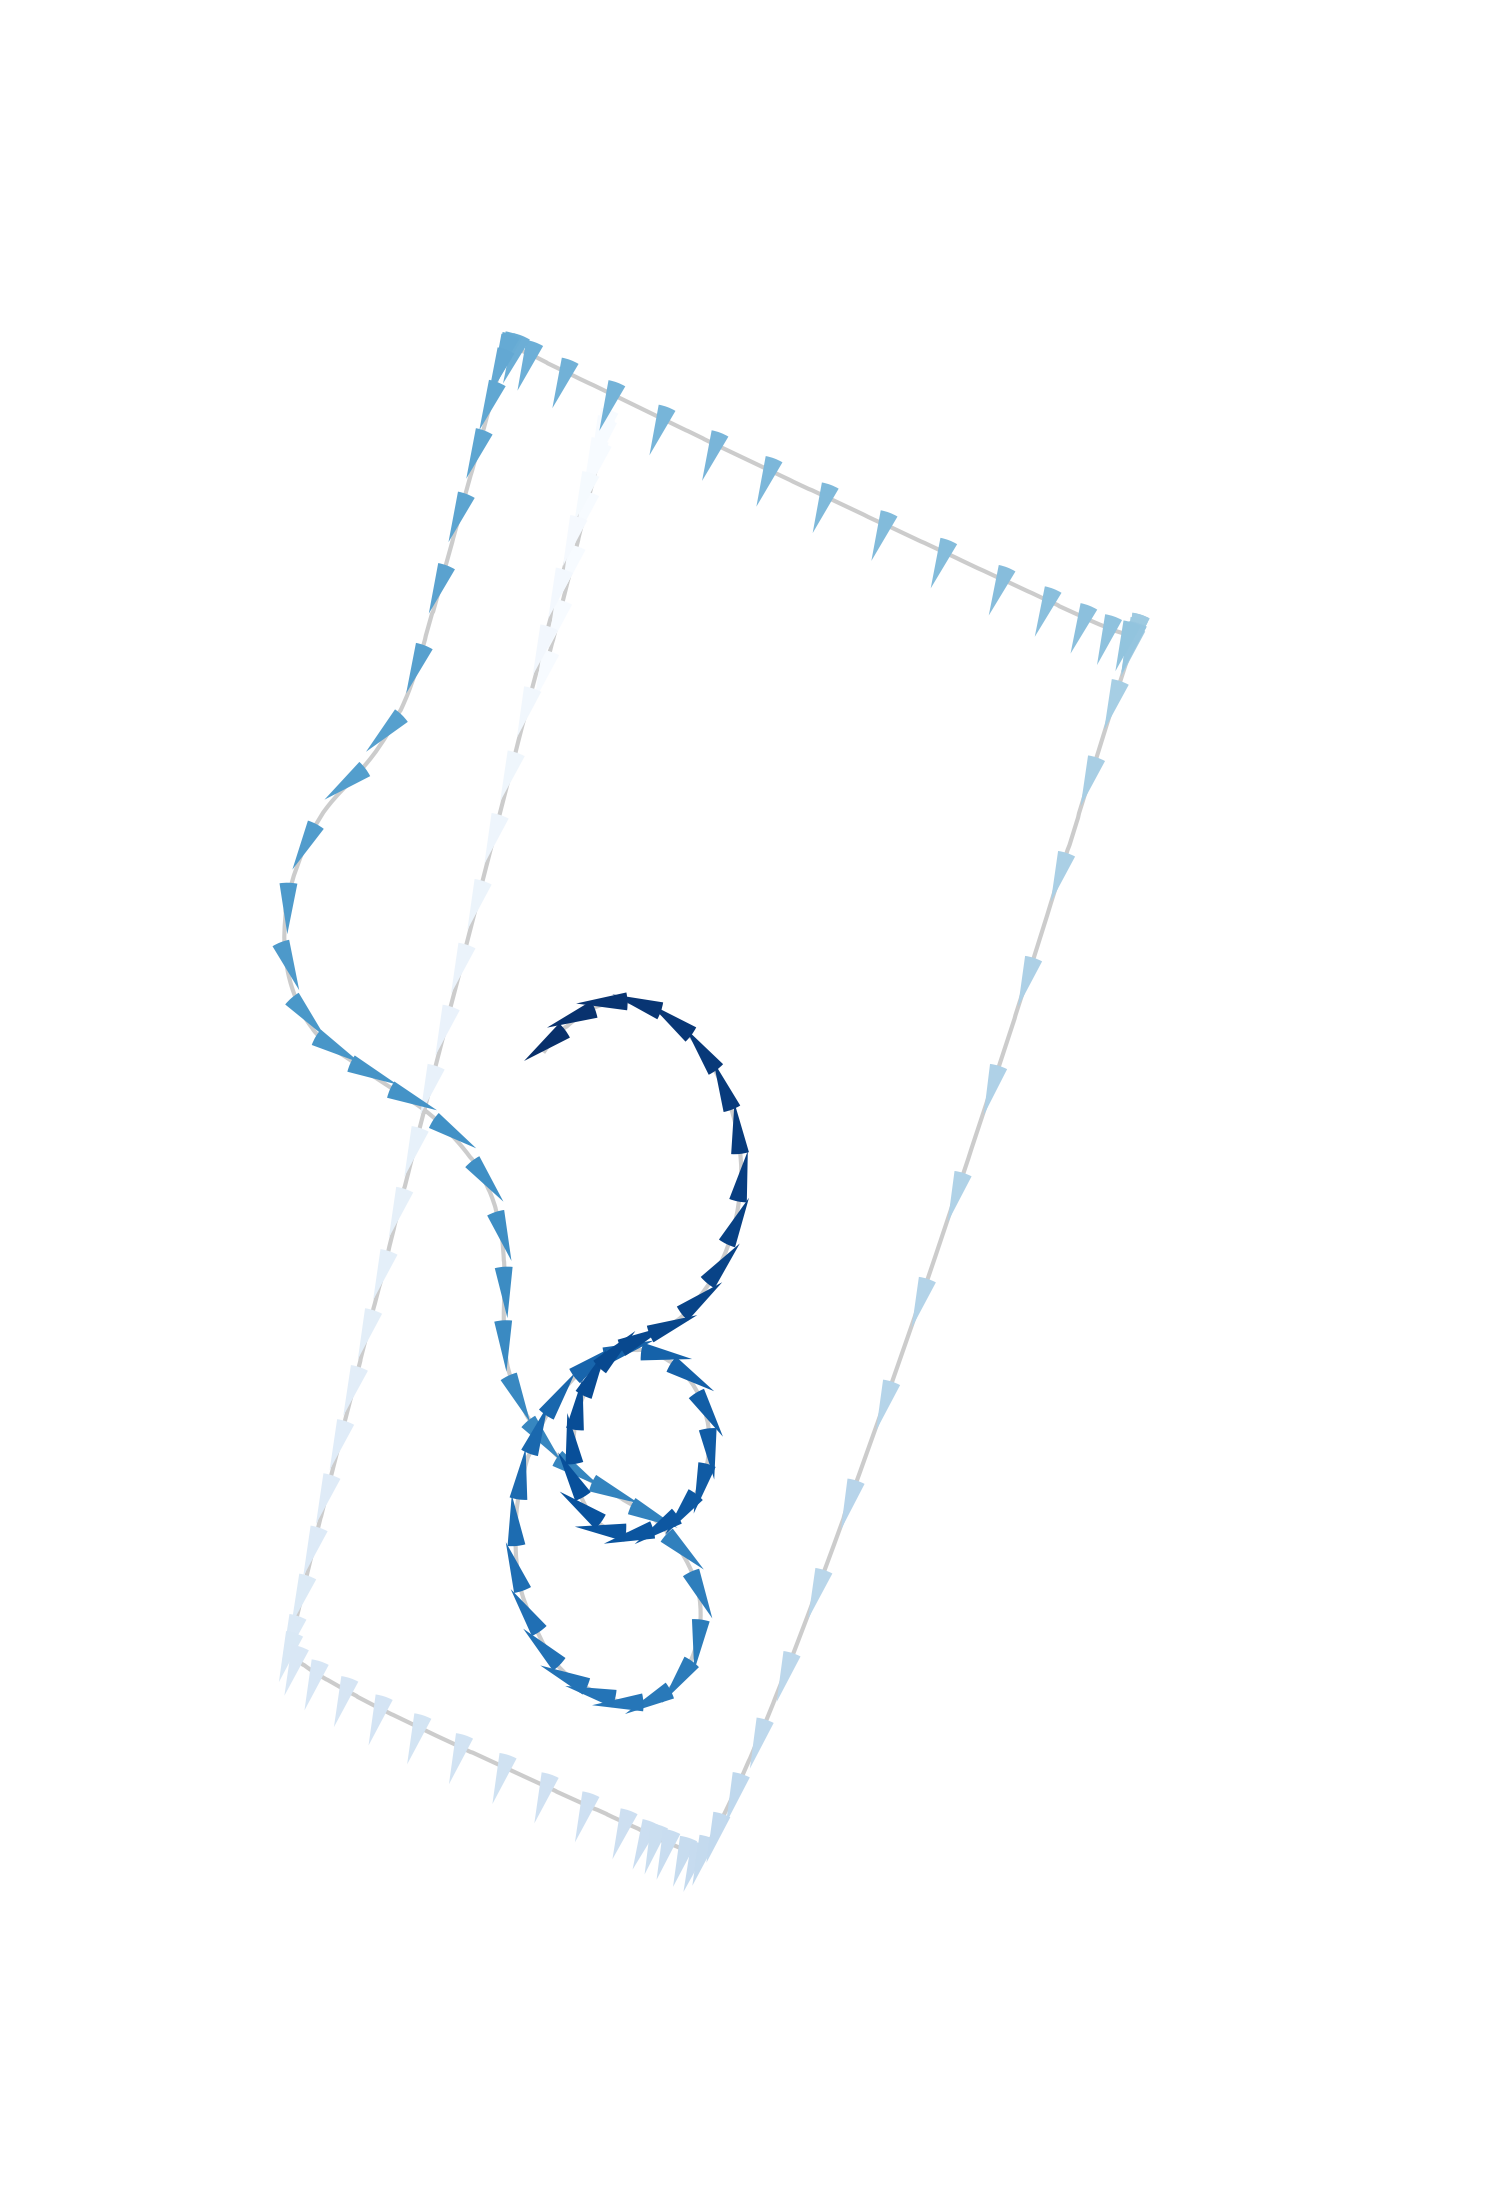

In [37]:
plotdata = df.copy()
plotdata['phi'] = -plotdata['phi'].values + np.deg2rad(90)
plotdata['w'] = plotdata['w_vector']
plotdata['zeta'] = plotdata['zeta_vector']
size_radius = 0.15*np.mean(np.abs(np.hstack((df['xpos'] , df['ypos']))))

fig = plt.figure(figsize=(4,4), dpi=600)
ax = fig.add_subplot(111)
plt.plot(plotdata.xpos, plotdata.ypos,
         color='black',
         alpha=0.2,
         linewidth=0.5, 
         zorder=1)
utility.plot_trajec(plotdata, ax=ax,
                    size_radius=size_radius,
                    nskip=30,
                    show_wind_quivers=False,
                    colormap='Blues') # bone_r

plt.savefig(figname + "_xytheta_2D.png")

## 3D trajectory

(4851, 1, 3)
(4850, 2, 3)


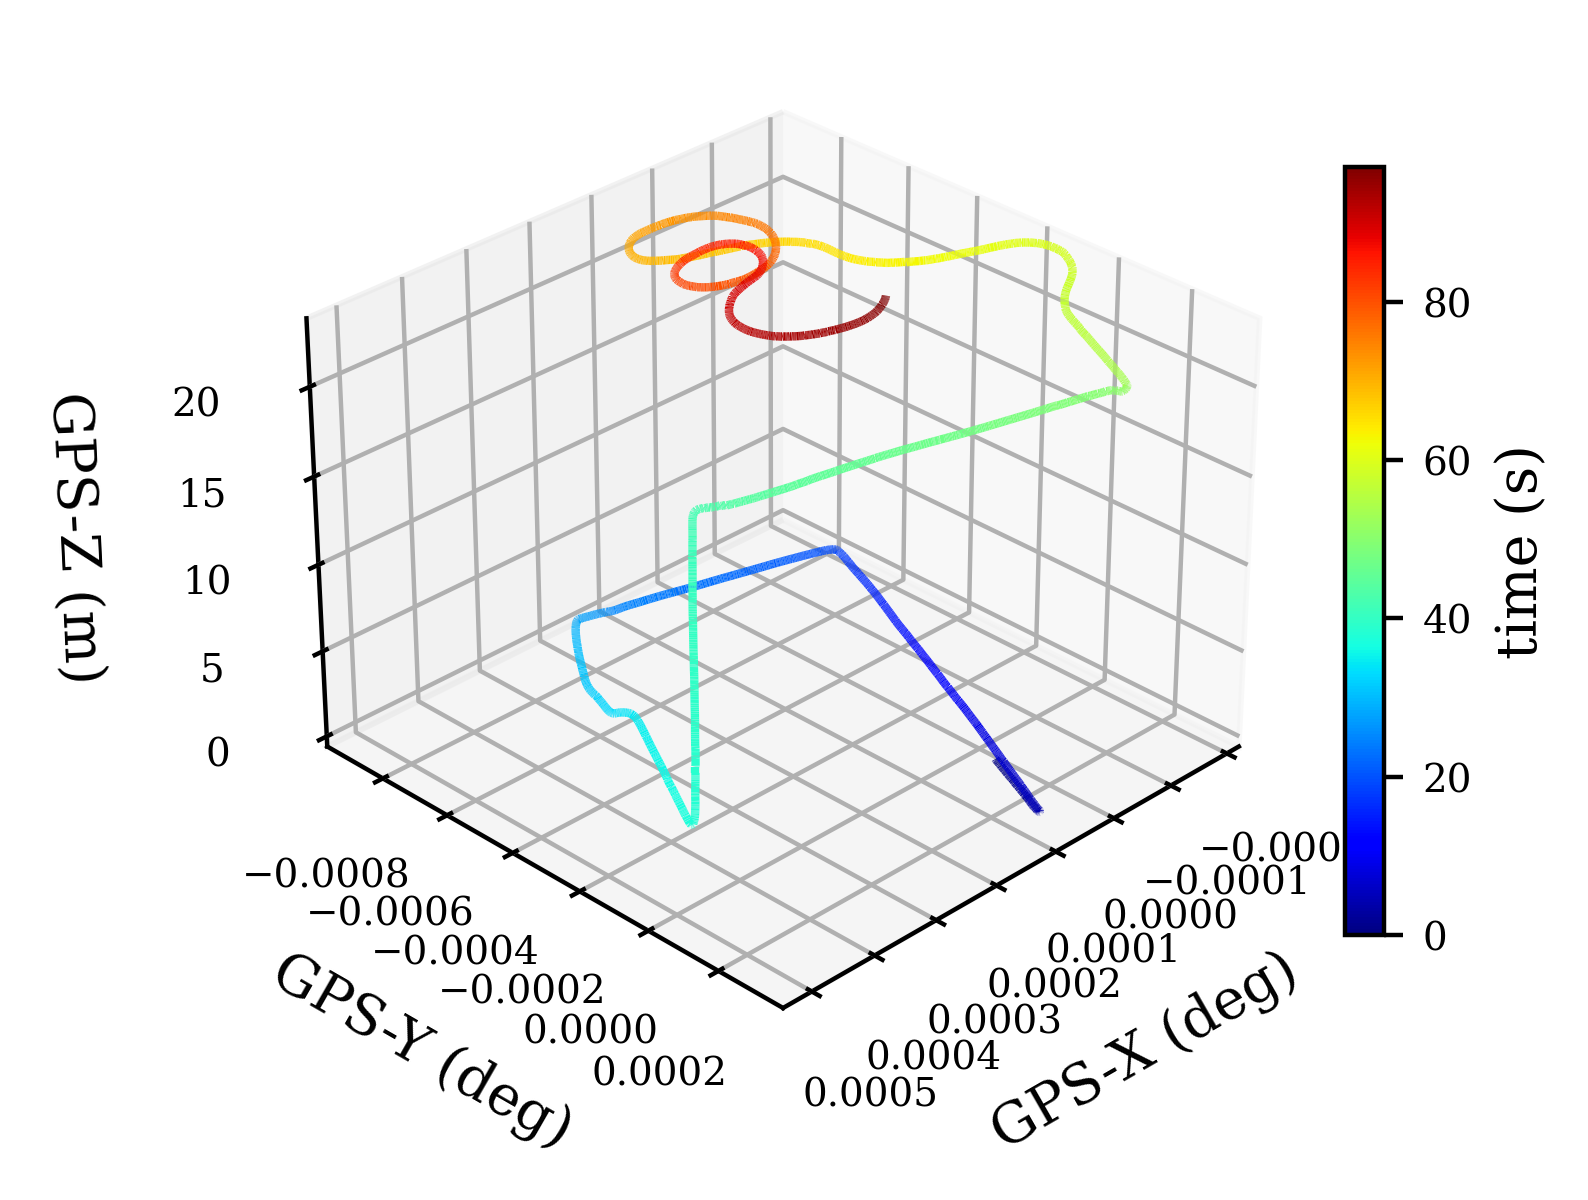

In [38]:
x = np.squeeze(np.array(df.xpos)) / 1000
y = np.squeeze(np.array(df.ypos)) / 1000
z = np.squeeze(np.array(df.zpos)) / 1000
z = z - z[0]
t = np.squeeze(np.array(df.t))

# generate a list of (x,y,z) points
points = np.array([x,y,z]).transpose().reshape(-1,1,3)
print(points.shape)  # Out: (len(x),1,3)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
print(segs.shape)  # Out: ( len(x)-1, 2, 3 )
                  # see what we've done here -- we've mapped our (x,y,z)
                  # points to an array of segment start/end coordinates.
                  # segs[i,0,:] == segs[i-1,1,:]

# make the collection of segments
lc = Line3DCollection(segs, cmap=plt.get_cmap('jet'))
lc.set_array(t) # color the segments by our parameter

fig = plt.figure(figsize=(8,6), dpi=400)
ax = fig.add_subplot(111, projection='3d')
ax.add_collection3d(lc)

cbar = fig.colorbar(lc, ax=ax, shrink=0.4)
cbar.set_label('time (s)') 
cbar.ax.tick_params(labelsize=7) 

ax.set_xlim(x.min(), x.max())
ax.set_ylim(y.min(), y.max())
ax.set_zlim(z.min(), z.max())

ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='z', labelsize=7)

ax.set_xlabel('GPS-X (deg)')
ax.set_ylabel('GPS-Y (deg)')
ax.set_zlabel('GPS-Z (m)')
ax.view_init(elev=30, azim=45)

left  = 0.5  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.1   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

plt.savefig(figname + "_3D_GPS.png")
plt.show()
